In [1]:
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras import layers, applications, losses
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D
import tensorflow.keras.backend as K
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import pathlib 
from pathlib import Path, PurePath

import skimage
from skimage.transform import resize

import sys
import os
import h5py

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback
import numpy as np
from PIL import Image

from tensorflow.python.framework.ops import enable_eager_execution
enable_eager_execution()


In [6]:
class VGG19AutoEncoder(tf.keras.Model):
    def __init__(self, files_path = "models/vgg_decoder"):
        super(VGG19AutoEncoder, self).__init__()
        #Load Full Model with every trained decoder
        
        
        #Get Each SubModel
        # Each model has an encoder, a decoder, and an extra output convolution
        # that converts the upsampled activations into output images
        
        # DO NOT load models four and five because they are not great auto encoders
        # and therefore will cause weird artifacts when used for style transfer 
        
        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0] # VGG encoder
        self.D3 = ModelBlock3.layers[1] # Trained decoder from VGG
        self.O3 = ModelBlock3.layers[2] # Conv layer to get to three channels, RGB image
        
        ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        self.E2 = ModelBlock2.layers[0] # VGG encoder
        self.D2 = ModelBlock2.layers[1] # Trained decoder from VGG
        self.O2 = ModelBlock2.layers[2] # Conv layer to get to three channels, RGB image
        
        # no special decoder for this one becasue VGG first layer has
        # no downsampling. So the decoder is just a convolution 
        ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        self.E1 = ModelBlock1.layers[0] # VGG encoder, one layer
        self.O1 = ModelBlock1.layers[1] # Conv layer to get to three channels, RGB image
        
    def call(self, image, alphas=None, training  = False):
        # Input will be the content image
        
        content_image = image
        
        output_dict = dict()
        # this will be the output, where each value is a styled 
        # version of the image at layer 1, 2, and 3. So each key in the 
        # dictionary corresponds to layer1, layer2, and layer3.
        # we also give back the reconstructed image from the auto encoder
        # so each value in the dict is a tuple (styled, reconstructed)
        
        # choose covariance function
        # covariance is more stable, but signal will work for very small images
        
        if alphas==None:
            alphas = {'layer3':0.6, 
                      'layer2':0.6, 
                      'layer1':0.6}
            
        print("Size of input: ", K.int_shape(content_image))
        
        # ------Layer 3----------
        # get reconstruction
        reconst3 = self.O3(self.D3(self.E3(tf.constant(content_image))))
        # save off the reconstructed images for display
        reconst3 = tf.clip_by_value(tf.squeeze(reconst3), 0, 1)
        output_dict['layer3'] = (reconst3)
        
        print("Size of reconst3: ", K.int_shape(reconst3))
        
        # ------Layer 2----------
        # get reconstruction
        reconst2 = self.O2(self.D2(self.E2(tf.constant(content_image))))
        # save off reconstructed images for display
        reconst2 = tf.clip_by_value(tf.squeeze(reconst2), 0, 1)
        output_dict['layer2'] = (reconst2)
        
        print("Size of reconst2: ", K.int_shape(reconst2))

        # ------Layer 1----------
        # get reconstruction
        reconst1 = self.O1(self.E1(tf.constant(content_image)))
        # save off the reconstructed images for display
        reconst1 = tf.clip_by_value(tf.squeeze(reconst1), 0, 1)
        output_dict['layer1'] = (reconst1)
        
        print("Size of reconst1: ", K.int_shape(reconst1))
           
        return output_dict

    @staticmethod
    def enhance_contrast(image, factor=1.25):
        return tf.image.adjust_contrast(image,factor)
        
    
       

Size of input:  (1, 512, 512, 3)
Size of reconst3:  (512, 512, 3)
Size of reconst2:  (512, 512, 3)
Size of reconst1:  (512, 512, 3)


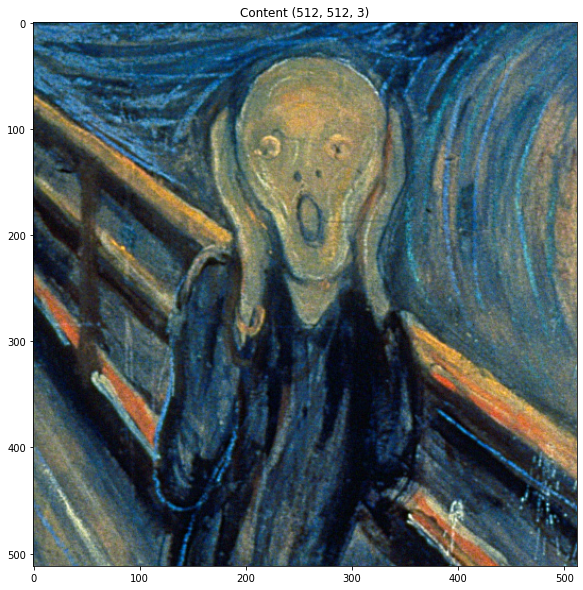

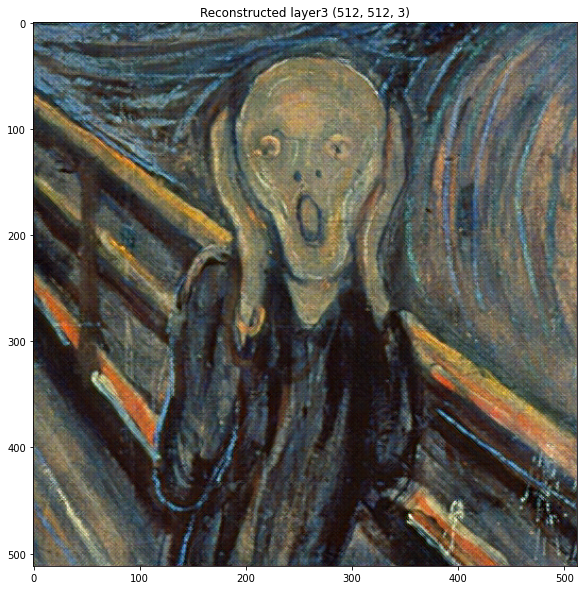

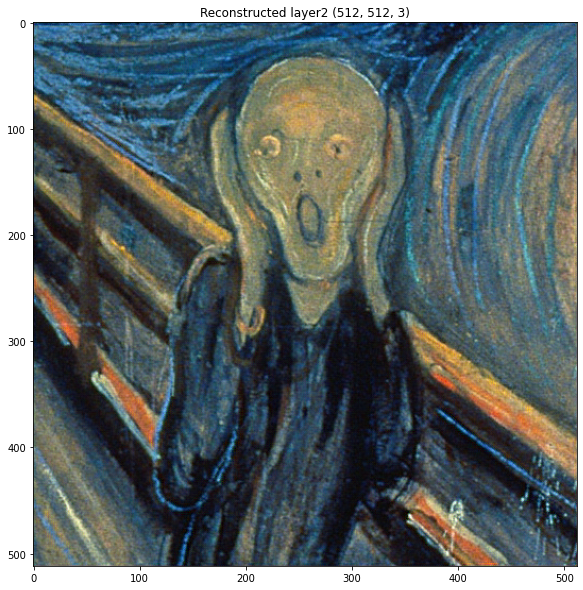

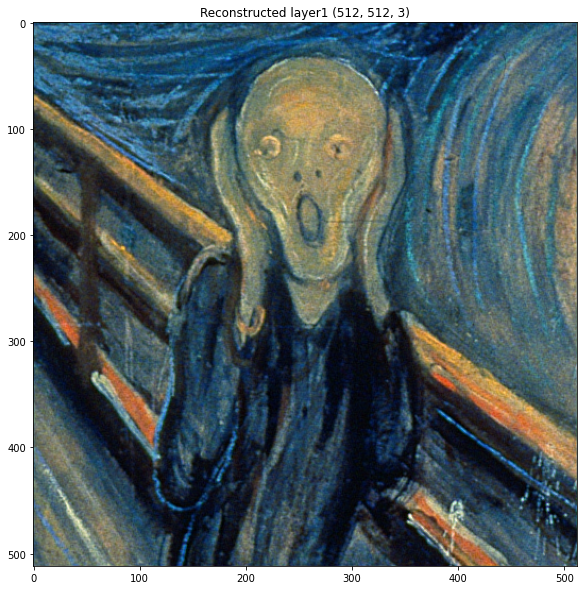

In [13]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    else:
        title += ' '+str(image.shape)
    plt.title(title)
    
AE = VGG19AutoEncoder('models/vgg_decoder/')

content_path = 'lab2_images/style.jpg'

content_image = load_img(content_path)
decoded_images = AE(content_image)

plt.figure(figsize=(10,10))
imshow(content_image,'Content')

for layer in decoded_images.keys():
    plt.figure(figsize=(10,10))
    imshow(decoded_images[layer],'Reconstructed '+layer)


In [11]:
decoded_images[layer][1]

<tf.Tensor: shape=(512, 3), dtype=float32, numpy=
array([[0.14135303, 0.2715657 , 0.331969  ],
       [0.1349445 , 0.26553464, 0.45194772],
       [0.09368803, 0.2836413 , 0.39287087],
       ...,
       [0.19810434, 0.37756377, 0.49481562],
       [0.19868505, 0.34826866, 0.49307802],
       [0.16996302, 0.36597118, 0.4552892 ]], dtype=float32)>